In [1]:
%load_ext autoreload
%autoreload 2

# Rx Fire Policy replication plots

In this notebook we generate the main plot of our simulations results and some supplementary figures explaining the simulation process: 
 - Fig 4: Main results from simulation: cost-benefit ratio
 - Sup 7: Severity-Emissions response function
 - Sup 6: Descriptives of simulation process.

In [2]:
import os

import duckdb
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from prescribed.estimate.simulations import (
    calculate_benefits,
    make_model,
)
from prescribed.plot import template_plots

matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42


# Set the font to be serif, rather than sans
plt.rcParams["font.family"] = "Helvetica Neue"

# Set the font size to be 12
plt.rcParams["font.size"] = 12

# Path for data
data_path = "/mnt/sherlock/oak/prescribed_data/"
sim_path = "/mnt/sherlock/oak/prescribed_data/processed/simulations"

How can we translate the policy in acres to our model parameters? We have to define the size of the treatments and the number of them to know how many 1 sq-km grids we need 

In [3]:
policy_size = 1_000_000
size_rx = 1_000

print(f"Number of policy 1 sq-km pixels: {policy_size / 247.105}")
print(
    f"If all fires are of {size_rx} acres, then the size is: {size_rx / 247.105} sq-km"
)
print(f"Number of fires in the policy area: {policy_size / size_rx}")

Number of policy 1 sq-km pixels: 4046.8626697153036
If all fires are of 1000 acres, then the size is: 4.046862669715304 sq-km
Number of fires in the policy area: 1000.0


In [4]:
# Load DNBR data and save to parquet to make it nicer for DuckDB
dnbr = pd.read_feather(
    os.path.join(data_path, "processed/dnbr_gee_inmediate/dnbr_long.feather")
).drop(columns=["spatial_ref"], errors="ignore")

dnbr["dnbr"] = np.where(dnbr.dnbr < 0, 0, dnbr.dnbr)

# Load MTBS dataset to add year to the DNBR data
mtbs = (
    gpd.read_file(
        os.path.join(
            data_path, "geoms/mtbs_perims_DD_updated/mtbs_perims_DD.shp"
        )
    )
    .to_crs("EPSG:3310")
    .drop(columns=["spatial_ref"], errors="ignore")
)

# Merge it to get years
mtbs["year"] = mtbs.Ig_Date.dt.year

dnbr = dnbr.merge(
    mtbs[["Event_ID", "year"]],
    right_on="Event_ID",
    left_on="event_id",
    how="left",
)
dnbr.drop(columns=["Event_ID"], inplace=True)

# Subset and save to parquet to make it nicer for DuckDB.
# Here we bottom code dnbr to avoid weird and large negative values
# dnbr["dnbr"] = np.where(dnbr.dnbr < 0, 0, dnbr.dnbr)

# Because of some dnbr issues (buffered data), we need to remove some of the data
# by using the templates we have from MTBS (remove grids in the buffer). We could
# normally do this by a spatial join, but we have a lot of data and it's slow.
treatments = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/treatments_mtbs.feather"
).drop(columns=["spatial_ref"], errors="ignore")

treatments_dnbr = treatments.merge(
    dnbr[["year", "dnbr", "lat", "lon", "grid_id"]],
    left_on=["lat", "lon", "year"],
    right_on=["lat", "lon", "year"],
    how="left",
)

# Clean treatments to only be in Event ID in California and have data
treatments_dnbr = treatments_dnbr[
    (treatments_dnbr.Event_ID.str.startswith("CA"))
    & (~treatments_dnbr.dnbr.isna())
]

# Add land type data
land_type = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/land_type/land_type.feather"
)
treatments_dnbr = treatments_dnbr.merge(
    land_type[["grid_id", "land_type"]], on="grid_id"
)

# Clean repeated observations for the same fire
treatments_dnbr_clean = treatments_dnbr.groupby(
    ["year", "Event_ID", "Incid_Name", "grid_id", "Ig_Date", "Incid_Type"],
    as_index=False,
).dnbr.max()

treatments_dnbr_clean.to_parquet("../data/dnbr.parquet")

### Calculate fire probabilities

In [5]:
wildfires_list = mtbs[
    (mtbs.Event_ID.str.startswith("CA"))
    & (mtbs.Incid_Type == "Wildfire")
    & (mtbs.Ig_Date.dt.year >= 2010)
].Event_ID.tolist()

treatments["year"] = treatments.Ig_Date.dt.year

probs = (
    treatments[treatments.Event_ID.isin(wildfires_list)].groupby("year").size()
    / 103475
).reset_index()
probs.rename(columns={0: "fire"}, inplace=True)

probs["num_fires"] = (
    mtbs[mtbs.Event_ID.isin(wildfires_list)].groupby("year").size().values
)

probs.to_csv("../data/results/probability_conifer_fire.csv", index=False)

In [6]:
probs = (
    treatments[treatments.Ig_Date.dt.year > 2010]
    .groupby(treatments.Ig_Date.dt.year, as_index=False)
    .size()
)

probs["fire"] = probs["size"] / 103475
probs.rename(columns={"Ig_Date": "year"}, inplace=True)
probs.to_csv("../data/results/probability_conifer_fire.csv", index=False)

### Calculate average severity for Rx fire and average observed severity

In [7]:
wildfires_list = mtbs[
    (mtbs.Event_ID.str.startswith("CA"))
    & (mtbs.Incid_Type == "Prescribed Fire")
].Event_ID.tolist()

dnbr[
    (dnbr.event_id.isin(wildfires_list))
    & (dnbr.grid_id.isin(land_type[land_type.land_type == 2].grid_id.tolist()))
].dnbr.mean()

62.806675

In [8]:
wildfires_list = mtbs[
    (mtbs.Event_ID.str.startswith("CA"))
    & (mtbs.Incid_Type == "Wildfire")
    & (mtbs.Ig_Date.dt.year >= 2010)
].Event_ID.tolist()

dnbr[(dnbr.event_id.isin(wildfires_list))].groupby(
    "year", as_index=False
).dnbr.mean().to_csv("../data/results/dnbr_values_year.csv", index=False)

### Distribution of severity of low-severity vs. prescribed

/home/topcat/miniforge3/envs/prescribed/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/topcat/miniforge3/envs/prescribed/lib/python3.10/site-packages/seaborn/axisgrid.py:854: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(*plot_args, **plot_kwargs)
/home/topcat/miniforge3/envs/prescribed/lib/python3.10/site-packages/seaborn/axisgrid.py:854: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(*plot_args, **plot_kwargs)
/home/topcat/miniforge3/envs/prescribed/lib/python3.10/site-packages/seaborn/axisgrid.py:854: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(*plot_args, **plot_kwargs)
/home/topcat/miniforge3/envs/prescribed/lib/python3.10/site-packages/seaborn/axisgrid.py:854: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(*plot

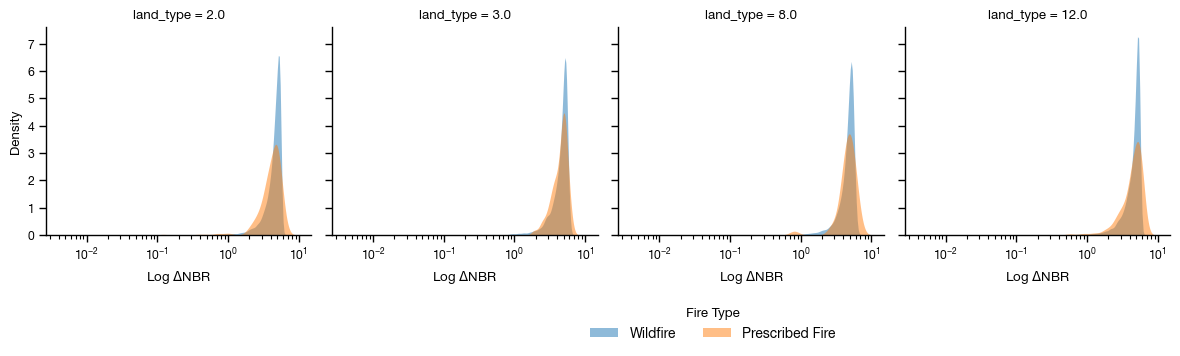

In [ ]:
land_types = {
    2.0: "conifers",
    12.0: "shrublands",
    3.0: "conifer-hardwood",
    8.0: "hardwood",
}

plot_data = treatments_dnbr_clean.merge(
    land_type[["grid_id", "land_type"]], on="grid_id"
)

# Subset to get only conifers!
plot_data = plot_data[plot_data.land_type.isin(land_types.keys())]

plot_data = plot_data[
    plot_data.Event_ID.isin(
        mtbs[
            mtbs.Incid_Type.isin(["Prescribed Fire", "Wildfire"])
        ].Event_ID.tolist()
    )
]

# Filter all Wildifre observations whose dnbr is larger than 269
plot_data = plot_data[
    ~((plot_data.Incid_Type == "Wildfire") & (plot_data.dnbr > 269))
]
plot_data["log_dnbr"] = np.log(plot_data.dnbr)

sns.set_context("paper")
g = sns.FacetGrid(data=plot_data, col="land_type", hue="Incid_Type")

g.map(
    sns.kdeplot,
    "log_dnbr",
    fill=True,
    alpha=0.5,
    linewidth=0,
    log_scale=True,
    palette=["#FF7F0E", "#1F77B4"],
    common_norm=False,
    multiple="layer",
    hue_order=["Wildfire", "Prescribed Fire"],
)

# Add legend at the bottom of the plot
g.add_legend(
    title="Fire Type",
    bbox_to_anchor=(0.5, 0.0),
    loc="upper center",
    ncol=2,
    fontsize=10,
)
g.set_axis_labels(r"Log $\Delta$NBR", "Density")

# Save as a PDF
plt.savefig(
    "../figs/dnbr_rx_lowseverity.pdf",
    bbox_inches="tight",
    dpi=300,
    transparent=True,
)

## Sup Fig 7: Explore $\Delta$ NBR relationship with PM $_{2.5}$ concentrations

Degree 1: RMSE = 19794.3644, R2 = 0.4574
Degree 2: RMSE = 20796.3793, R2 = 0.4011
Degree 3: RMSE = 20942.1848, R2 = 0.3926
Degree 4: RMSE = 21788.1551, R2 = 0.3426
Degree 5: RMSE = 23046.0451, R2 = 0.2645
Degree 6: RMSE = 23765.5567, R2 = 0.2178
Degree 7: RMSE = 23859.2619, R2 = 0.2117
Degree 8: RMSE = 23529.9550, R2 = 0.2333


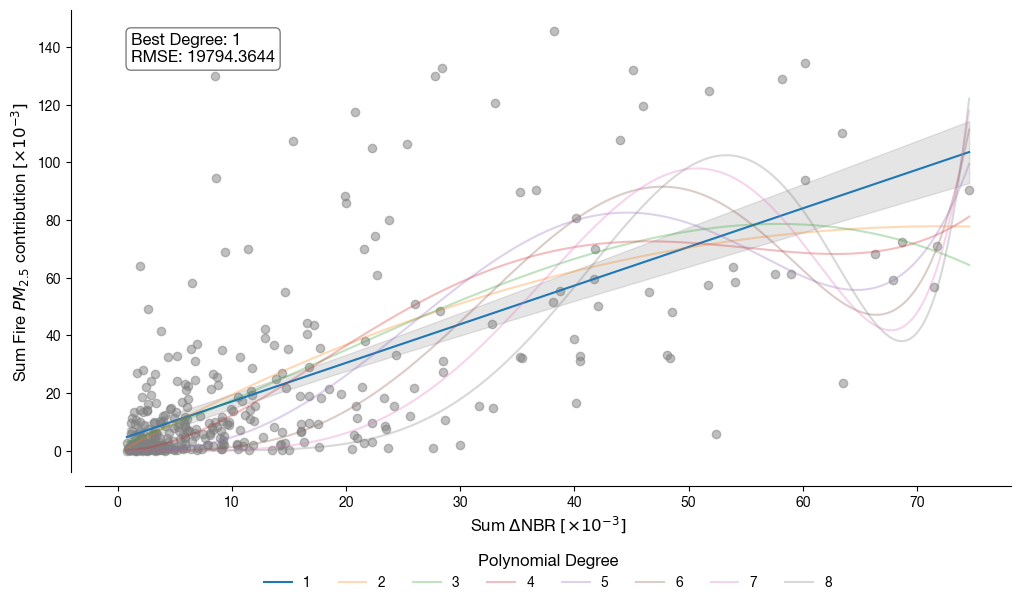

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures


def find_best_polynomial_fit(
    data,
    x_col,
    y_col,
    degrees=range(1, 9),
    test_size=0.2,
    random_state=42,
    remove_outliers=False,
    quantile_range=(0.025, 0.975),
):
    """
    Finds the best polynomial fit between two columns in a DataFrame using RMSE and R-squared.

    Parameters
    ----------
    data : pd.DataFrame
        The input DataFrame containing the data.
    x_col : str
        The name of the column to use as the independent variable.
    y_col : str
        The name of the column to use as the dependent variable.
    degrees : range, optional
        The range of polynomial degrees to test, by default range(1, 9).
    test_size : float, optional
        The proportion of the data to use as the test set, by default 0.2.
    random_state : int, optional
        The random seed for reproducibility, by default 42.
    remove_outliers : bool, optional
        Whether to remove outliers from the data, by default False.
    quantile_range : tuple, optional
        The lower and upper quantiles to use for outlier removal, by default (0.025, 0.975).

    Returns
    -------
    None
    """
    # Optionally remove outliers
    if remove_outliers:
        lower_x, upper_x = data[x_col].quantile(quantile_range)
        lower_y, upper_y = data[y_col].quantile(quantile_range)
        data = data[
            (data[x_col] >= lower_x)
            & (data[x_col] <= upper_x)
            & (data[y_col] >= lower_y)
            & (data[y_col] <= upper_y)
        ]

    # Split the data into train and test sets
    X = data[[x_col]].values
    y = data[y_col].values
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # Store RMSE and R-squared values for each degree
    rmse_scores = []
    r2_scores = []

    # Plot setup
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.scatter(X / 1000, y / 1000, color="gray", alpha=0.5)

    # Loop through polynomial degrees
    for degree in degrees:
        # Create polynomial features
        poly = PolynomialFeatures(degree=degree)
        X_train_poly = poly.fit_transform(X_train)
        X_test_poly = poly.transform(X_test)

        # Fit the model using statsmodels
        model = sm.OLS(y_train, X_train_poly).fit()

        # Predict on the test set
        y_pred = model.predict(X_test_poly)

        # Calculate RMSE
        residuals = y_test - y_pred
        rmse = np.sqrt(np.mean(residuals**2))
        rmse_scores.append((degree, rmse))

        # Calculate R-squared
        ss_total = np.sum((y_test - np.mean(y_test)) ** 2)
        ss_residual = np.sum(residuals**2)
        r2 = 1 - (ss_residual / ss_total)
        r2_scores.append((degree, r2))

        # Plot the fit
        X_plot = np.linspace(X.min(), X.max(), 500).reshape(-1, 1)
        X_plot_poly = poly.transform(X_plot)
        y_plot = model.predict(X_plot_poly)
        ax.plot(
            X_plot / 1000,
            y_plot / 1000,
            label=f"{degree}",
            alpha=1 if degree == 1 else 0.3,
        )

        # Calculate confidence intervals for the predictions
        if degree == 1:
            predictions = model.get_prediction(X_plot_poly)
            ci = predictions.conf_int(alpha=0.05)
            ci_lower = ci[:, 0]
            ci_upper = ci[:, 1]
            ax.fill_between(
                X_plot.squeeze() / 1000,
                ci_lower / 1000,
                ci_upper / 1000,
                color="gray",
                alpha=0.2,
            )

    # Display RMSE and R-squared scores
    for degree, rmse, r2 in zip(degrees, rmse_scores, r2_scores):
        print(f"Degree {degree}: RMSE = {rmse[1]:.4f}, R2 = {r2[1]:.4f}")

    # Add best RMSE and degree to the plot as text
    best_degree = min(rmse_scores, key=lambda x: x[1])[0]
    best_rmse = min(rmse_scores, key=lambda x: x[1])[1]
    ax.text(
        0.05,
        0.95,
        f"Best Degree: {best_degree}\nRMSE: {best_rmse:.4f}",
        transform=ax.transAxes,
        fontsize=12,
        verticalalignment="top",
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.5),
    )

    # Move legend to the bottom of the plot outside the plotting area
    ax.legend(
        loc="upper center",
        bbox_to_anchor=(0.5, -0.15),
        ncol=len(degrees),
        fontsize=10,
        frameon=False,
        title="Polynomial Degree",
    )
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.2)

    template_plots(
        ax,
        xlab=r"Sum $\Delta$NBR $[\times 10^{-3}]$",
        ylab=r"Sum Fire $PM_{2.5}$ contribution $[\times 10^{-3}]$ ",
    )


smoke_linked = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/smoke_linking/severity_emissions_linked.feather"
)


# Assuming `smoke_linked` is your DataFrame
find_best_polynomial_fit(
    smoke_linked,
    x_col="sum_severity",
    y_col="sum_contrib",
    degrees=range(1, 9),
    remove_outliers=True,
    quantile_range=(0.025, 0.90),
)

# Save the plot as a PDF
plt.savefig(
    "../figs/smoke_linked_polynomial_fit.pdf",
    bbox_inches="tight",
    dpi=300,
    transparent=True,
)

### Explore coverage of datasets and marginal effects

/tmp/ipykernel_3040192/179961673.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_fires["sample"] = "All Fires"
/tmp/ipykernel_3040192/179961673.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_fires["sample"] = "Matched Fires"


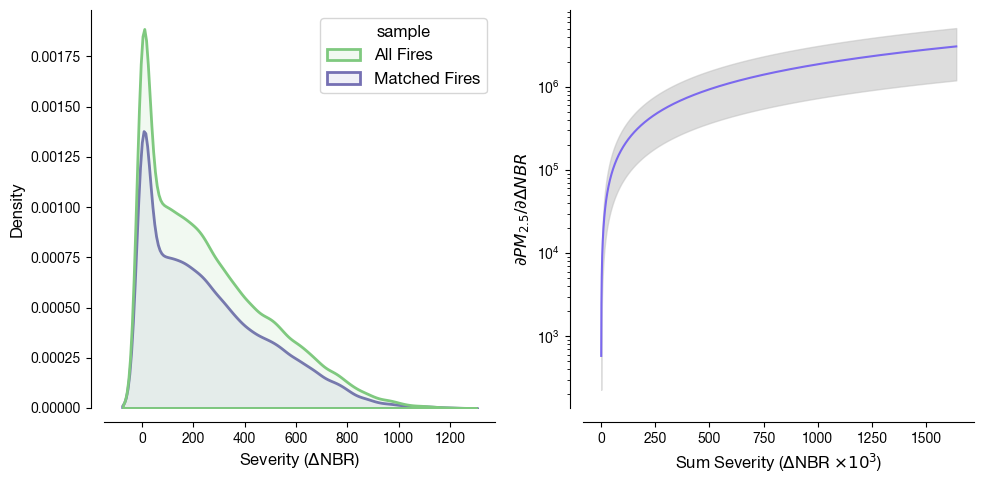

In [ ]:
smoke_linked = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/smoke_linking/severity_emissions_linked.feather"
)

# Change year type to avoid problems
smoke_linked["year"] = smoke_linked.year.astype(int)

coefs = make_model(
    smoke_linked,
    formula="sum_contrib ~ sum_severity + total_pixels + total_days | year",
    bootstrap=True,
    k=999,
)

# Estimate boostrap confidence intervals for marginal effects

# Range of severities
range_severity = np.arange(
    smoke_linked["sum_severity"].min(),
    smoke_linked["sum_severity"].max(),
    100,
)

# Multiply the second column of coef by the range of severities
boot_samples = []
for i in range(999):
    boot_samples.append(coefs[i, 0] * range_severity)

boots = np.vstack(boot_samples)
bounds = np.percentile(boots, [2.5, 0.5, 97.5], axis=0)

# Plot the predictions
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Create a dataframe to plot the density of the dnbr values for all fires
# and the matched fires

all_fires = treatments_dnbr_clean[treatments_dnbr_clean.year > 2006]
all_fires["sample"] = "All Fires"

matched_fires = treatments_dnbr_clean[
    (treatments_dnbr_clean.year > 2006)
    & (treatments_dnbr_clean.Event_ID.isin(smoke_linked.event_id.tolist()))
]
matched_fires["sample"] = "Matched Fires"
data_dist = pd.concat([all_fires, matched_fires])


# treatments_dnbr_clean[treatments_dnbr_clean.year > 2006].dnbr.plot.density(
#     ax=ax[0], color="#7570b3", linewidth=2
# )
# treatments_dnbr_clean[
#     (treatments_dnbr_clean.year > 2006)
#     & (treatments_dnbr_clean.Event_ID.isin(smoke_linked.event_id.tolist()))
# ].dnbr.plot.density(ax=ax[0], color="#7fc97f", linewidth=2,)

sns.kdeplot(
    data=data_dist,
    x="dnbr",
    hue="sample",
    ax=ax[0],
    palette=["#7fc97f", "#7570b3"],
    common_norm=True,
    fill=True,
    linewidth=2,
    alpha=0.1,
)


# Apply template
template_plots(ax[0], xlab="Severity ($\Delta$NBR)", ylab="Density")

# # Add a legend for the two density lines
# ax[0].legend(["All Fires", "Matched Fires"], loc="upper right")

# Plot marginal effect of severity on emissions using log scale
ax[1].set_yscale("log")
ax[1].fill_between(
    range_severity / 1000,
    bounds[0],
    bounds[2],
    alpha=0.5,
    color="#bdbdbd",
)

# Plot median prediction as a line
ax[1].plot(
    range_severity / 1000,
    np.mean(boots, axis=0),
    color="mediumslateblue",
)

# Apply template
template_plots(
    ax[1],
    xlab="Sum Severity ($\Delta$NBR $\\times 10^{3} $)",
    ylab="$\partial PM_{2.5} / \partial \Delta NBR$",
)

plt.tight_layout()

# Save as a PDF
plt.savefig(
    "../figs/severity_emissions_link.pdf",
    bbox_inches="tight",
    dpi=300,
    transparent=True,
)


## Fig 4: Discounted benefit-cost ratio for two types of simulation (w/ and wo/ spillovers)

In [22]:
# Set seed numpy
np.random.seed(42)

# Load smoke link data
smoke_linked = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/smoke_linking/severity_emissions_linked.feather"
)

# Avoid prediction errors
smoke_linked["year"] = smoke_linked.year.astype(int)

benefits_no_spill, sims = calculate_benefits(
    n_treats=4000,
    path=f"{sim_path}/policy_no_spill_4000_large_4000",
    # path="../data/policy_no_spill_4000/",
    discount_rates=[0.02, 0.04, 0.06, 0.1],
    treat_severity=100,
    average_treats=True,
    linked_data=smoke_linked,
    formula="sum_contrib ~ sum_severity + total_pixels + total_days | year",
    bootstrap=True,
    predict=True,
)
benefits_no_spill["treatment"] = "No Spill"

benefits_spill, sims_spill = calculate_benefits(
    n_treats=1000,
    path=f"{sim_path}/policy_spill_large_150",
    discount_rates=[0.02, 0.04, 0.06, 0.1],
    treat_severity=100,
    average_treats=True,
    linked_data=smoke_linked,
    formula="sum_contrib ~ sum_severity + total_pixels + total_days | year",
    bootstrap=True,
    predict=True,
)
benefits_spill["treatment"] = "Spillovers"

benefits = pd.concat([benefits_no_spill, benefits_spill])

Bootstrapping model results/coefficients: 100%|██████████| 999/999 [00:40<00:00, 24.51it/s]
/home/topcat/projects/extract/src/prescribed/estimate/simulations.py:467: UserWarning: 0.0316% of rows were removed
  warnings.warn(f"{prop:.4f}% of rows were removed")
Bootstrapping model results/coefficients: 100%|██████████| 999/999 [00:28<00:00, 35.39it/s]
/home/topcat/projects/extract/src/prescribed/estimate/simulations.py:467: UserWarning: 0.0114% of rows were removed
  warnings.warn(f"{prop:.4f}% of rows were removed")
Bootstrapping model results/coefficients: 100%|██████████| 999/999 [00:28<00:00, 34.60it/s]


In [23]:
smoke_linked

,event_id,mean_severity,sum_severity,median_severity,pixels_low_severity,pixels_mod_low_severity,pixels_mod_high_severity,pixels_high_severity,share_low_severity,share_high_severity,total_pixels,sum_contrib,mean_contrib,total_days,median_smokepm,sum_contrib_km,sum_severity_km,year
0,CA3260811624320120517,52.611077,683.944000,4.463023,13,0,0,0,1.000000,0.000000,13,1744.970588,0.879965,4.0,0.195522,134.228507,52.611077,2012
1,CA3260811664120160619,87.873249,9226.691115,13.024886,91,8,5,1,0.866667,0.009524,105,3648.087230,1.352145,8.0,0.773650,34.743688,87.873249,2016
2,CA3264611677120071021,128.078348,94906.055918,53.693092,600,78,57,6,0.809717,0.008097,741,40792.882205,1.756572,18.0,0.887917,55.051123,128.078348,2007
3,CA3264811636520120923,115.915095,2897.877365,22.890451,20,3,2,0,0.800000,0.000000,25,0.000000,NaN,5.0,NaN,0.000000,115.915095,2012
4,CA3265211682420170520,116.488795,1980.309517,78.188004,14,3,0,0,0.823529,0.000000,17,543.660999,2.036184,6.0,1.252296,31.980059,116.488795,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
483,CA4194712334920170808,126.836665,14205.706512,10.141549,95,4,4,9,0.848214,0.080357,112,1884.740266,15.199518,2.0,16.251323,16.828038,126.836665,2017
484,CA4195612355120180715,94.982031,35428.297633,10.861579,329,35,9,0,0.882038,0.000000,373,447727.736716,2.545745,61.0,0.877048,1200.342458,94.982031,2018
485,CA4196012323320120805,173.067034,1384.536276,49.621383,7,0,0,1,0.875000,0.125000,8,13380.082346,1.108265,9.0,0.198970,1672.510293,173.067034,2012
486,CA4197112054520070710,131.170249,11805.322417,0.000000,71,8,7,4,0.788889,0.044444,90,2002.378939,0.886008,4.0,0.297223,22.248655,131.170249,2007


In [24]:
sims[sims.event_id.isin(smoke_linked.event_id.tolist())]

,event_id,event_name,year,sum_dnbr,year_treat,sim,simulated_sum_dnbr,sum_benefit_event,preds_pm,preds_sim_pm,benefit
0,CA3327711653720110721,EAGLE,2011,12450.776077,2010,1,12450.776077,0.000000,22837.702835,22837.702835,0.000000
1,CA3327711653720110721,EAGLE,2011,12450.776077,2010,2,12450.776077,0.000000,25108.489063,25108.489063,0.000000
2,CA3327711653720110721,EAGLE,2011,12450.776077,2010,3,12249.917019,200.859057,16904.471667,16631.764470,272.707197
3,CA3327711653720110721,EAGLE,2011,12450.776077,2010,4,12450.776077,0.000000,15820.763760,15820.763760,0.000000
4,CA3327711653720110721,EAGLE,2011,12450.776077,2010,5,12450.776077,0.000000,6718.478656,6718.478656,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
3179812,CA4185812335420200908,SLATER,2020,304447.157498,2019,995,295529.617631,8917.539868,611020.589382,593123.229096,17897.360286
3179813,CA4185812335420200908,SLATER,2020,304447.157498,2019,996,292601.927783,11845.229715,735933.265656,707300.058309,28633.207347
3179814,CA4185812335420200908,SLATER,2020,304447.157498,2019,997,294781.859736,9665.297762,445757.262322,431605.786231,14151.476090
3179815,CA4185812335420200908,SLATER,2020,304447.157498,2019,998,288723.495121,15723.662377,484146.610713,459142.081486,25004.529227


In [53]:
sims.groupby(["year_treat", "year"]).preds_sim_pm.mean()

year_treat  year
2010        2011     11590.351248
            2012     31587.683750
            2013     49813.485815
            2014     41159.982181
            2015     38920.124800
                        ...      
2018        2020    142369.934850
            2021    186306.653517
2019        2020    142429.084942
            2021    186492.166548
2020        2021    185993.999738
Name: preds_sim_pm, Length: 66, dtype: float64

In [54]:
a = (
    sims[sims.event_id.isin(smoke_linked.event_id.tolist())]
    .groupby(["year_treat", "year"], as_index=False)
    .preds_sim_pm.mean()
    .groupby("year")
    .sum()
)

b = (
    sims[sims.event_id.isin(smoke_linked.event_id.tolist())]
    .groupby(["year", "year_treat"], as_index=False)
    .preds_pm.mean()
    .groupby("year")
    .sum()
)

((b.preds_pm / a.preds_sim_pm) - 1).cumsum()

year
2011    0.005671
2012    0.020331
2013    0.036730
2014    0.061897
2015    0.073013
2016    0.088597
2017    0.101913
2018    0.111848
2019    0.126262
2020    0.141645
dtype: float64

In [48]:
sims.groupby(["year"]).preds_sim_pm.mean() / smoke_linked.groupby(
    ["year"]
).sum_contrib.mean()

year
2006         NaN
2007         NaN
2008         NaN
2009         NaN
2010         NaN
2011    1.261338
2012    0.362947
2013    0.568160
2014    1.044660
2015    0.475545
2016    0.789656
2017    0.560511
2018    0.276127
2019    0.858266
2020    0.434988
2021         NaN
dtype: float64

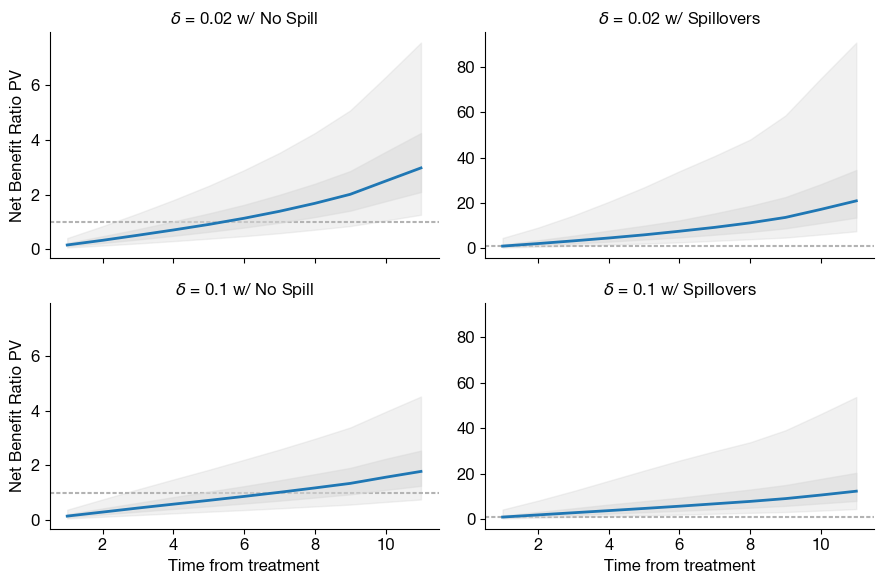

In [27]:
# remove weird ratios
benefits = benefits.dropna()

# Select only the discount rates we want to plot
deltas = [0.02, 0.1]
benefits = benefits[benefits.discount_rate.isin(deltas)]

mean_benefits = (
    benefits.groupby(["lag", "discount_rate", "treatment"])
    .ratio.median()
    .reset_index()
)

g = sns.relplot(
    data=mean_benefits,
    x="lag",
    y="ratio",
    row="discount_rate",
    col="treatment",
    kind="line",
    height=3,
    aspect=1.5,
    linewidth=2,
    zorder=5,
    legend=False,
    facet_kws={"sharey": "col", "sharex": True},
)

(
    g.map(plt.axhline, y=1, color=".7", dashes=(2, 1), zorder=0)
    .set_axis_labels("Time from treatment", "Net Benefit Ratio PV")
    .set_titles(r"$\delta$ = {row_name} w/ {col_name}")
    .tight_layout(w_pad=0)
)

colors = sns.color_palette(
    "crest", n_colors=len(mean_benefits["discount_rate"].unique())
)

# Plot the 0.25 and 0.975 quantiles for each discount rate and lag
iqr = (
    benefits.groupby(["lag", "discount_rate", "treatment"])
    .ratio.quantile([0.25, 0.75])
    .unstack()
    .reset_index()
)

# Plot the 0.025 and 0.975 quantiles for each discount rate and lag
ci = (
    benefits.groupby(["lag", "discount_rate", "treatment"])
    .ratio.quantile([0.05, 0.95])
    .unstack()
    .reset_index()
)

stds = (
    benefits.groupby(["lag", "discount_rate", "treatment"])
    .ratio.std(ddof=2)
    .reset_index()
)

ci_alt = pd.DataFrame(
    {
        "ci_low": mean_benefits.ratio - 1.96 * stds.ratio / np.sqrt(988),
        "ci_high": mean_benefits.ratio + 1.96 * stds.ratio / np.sqrt(988),
        "lag": mean_benefits.lag,
        "discount_rate": mean_benefits.discount_rate,
        "treatment": mean_benefits.treatment,
    }
)

for idxs, ax in g.axes_dict.items():
    dr, treat = idxs
    # Get the quantiles
    q_dr = ci[(ci.discount_rate == dr) & (ci.treatment == treat)]
    q_dr_iqr = iqr[(iqr.discount_rate == dr) & (iqr.treatment == treat)]

    ax.fill_between(
        q_dr.lag,
        q_dr[0.05],
        q_dr[0.95],
        color="#bdbdbd",
        # color=colors[list(mean_benefits["discount_rate"].unique()).index(dr)],
        alpha=0.2,
    )

    ax.fill_between(
        q_dr.lag,
        q_dr_iqr[0.25],
        q_dr_iqr[0.75],
        color="#d9d9d9",
        alpha=0.5,
        # color=colors[list(mean_benefits["discount_rate"].unique()).index(dr)],
    )
    # plt.yscale("asinh", shift=10)
    # ax.set_yscale("log")


plt.tight_layout()

# # Save plot
# plt.savefig(
#     "../figs/pv_benefits_pe_avg.pdf",
#     bbox_inches="tight",
#     dpi=300,
#     transparent=True,
# )


In [28]:
iqr[(iqr.treatment == "Spillovers") & (iqr.lag == 10)]

,lag,discount_rate,treatment,0.25,0.75
37,10,0.02,Spillovers,11.198681,28.316128
39,10,0.10,Spillovers,6.984774,17.766642


In [29]:
ci[(ci.treatment == "Spillovers") & (ci.lag == 10)]

,lag,discount_rate,treatment,0.05,0.95
37,10,0.02,Spillovers,6.151043,74.857746
39,10,0.10,Spillovers,3.825926,46.344213


### Plot example of simulation fire event

In [ ]:
path = f"{sim_path}/policy_no_spill_4000_large_4000"
df = duckdb.query(f"""
WITH simulation_data AS (
    SELECT *
    FROM '{path}/*.parquet'
    where sim is not null
), 
dnbr_data AS (
select
        grid_id, 
        year, 
        Event_ID as event_id, 
        Incid_Name as event_name, 
        dnbr 
from '../data/dnbr.parquet' 
where year > 2010
), 
dnbr_event_agg as (
select event_id, 
    event_name,      
    year,
    sum(dnbr) as sum_dnbr
from dnbr_data
group by event_id, event_name, year
), 
benefits_grid_simulation as (
SELECT  s.grid_id, 
        s.year_treat, 
        s.year, 
        d.event_id, 
        d.event_name, 
        s.sim,
        s.coeff, 
        d.dnbr,
        case when (d.dnbr + s.coeff) < 0 
                then 0 
                else d.dnbr + s.coeff 
        end as sim_benefit
from simulation_data s 
inner join dnbr_data d
on s.grid_id = d.grid_id 
    and s.year = d.year
) select grid_id, year_treat, event_id, event_name, mean(sim_benefit) as mean_benefit
from benefits_grid_simulation
where event_id == 'CA3720111927220200905' and year
group by grid_id, year_treat, event_id, event_name
""").to_df()

grids_fire = treatments_dnbr[
    treatments_dnbr.Event_ID == "CA3720111927220200905"
][["grid_id", "lat", "lon"]]

df = df.merge(grids_fire, on="grid_id")

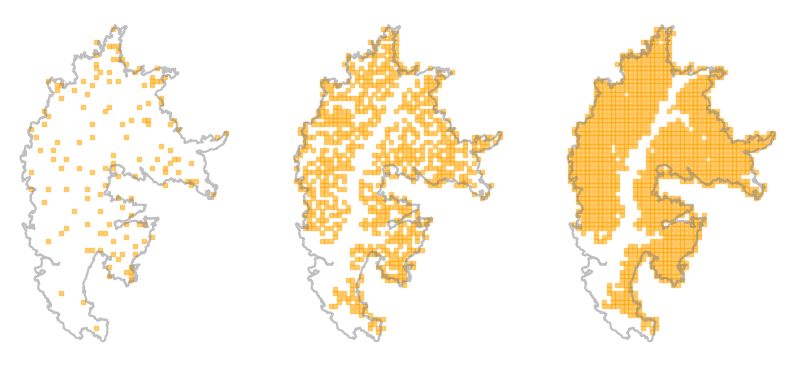

In [ ]:
# Total treats
treat_time = df.groupby(
    ["grid_id", "lat", "lon"], as_index=False
).year_treat.first()


years_plot = [2010, 2015, 2020]

# Plot each year in df as scatter
fig, ax = plt.subplots(1, len(years_plot), figsize=(10, 10))

for ax, year in zip(ax.flatten(), years_plot):
    data = treat_time[treat_time.year_treat <= year]
    ax.scatter(data.lon, data.lat, marker=",", s=5, c="orange", alpha=0.5)
    mtbs[mtbs.Event_ID == "CA3720111927220200905"].geometry.boundary.plot(
        ax=ax, color="gray", alpha=0.5
    )
    ax.axis("off")

# Save plot as PDF
plt.savefig(
    "../figs/treats_fire_creek.pdf",
    bbox_inches="tight",
    dpi=300,
    transparent=True,
)

In [ ]:
(treat_time.groupby("year_treat").grid_id.count().cumsum()) / 1772

year_treat
2010    0.080135
2011    0.161400
2012    0.239278
2013    0.308691
2014    0.388262
2015    0.467833
2016    0.544582
2017    0.628104
2018    0.694695
2019    0.764108
Name: grid_id, dtype: float64

In [ ]:
df_complete = treatments_dnbr[
    treatments_dnbr.Event_ID == "CA3720111927220200905"
][["grid_id", "dnbr", "lat", "lon"]].merge(
    df, on=["grid_id", "lat", "lon"], how="left"
)
df_complete["mean_benefit"] = df_complete.mean_benefit.fillna(df_complete.dnbr)

df_complete["pixel_benefit"] = df_complete.dnbr - df_complete.mean_benefit

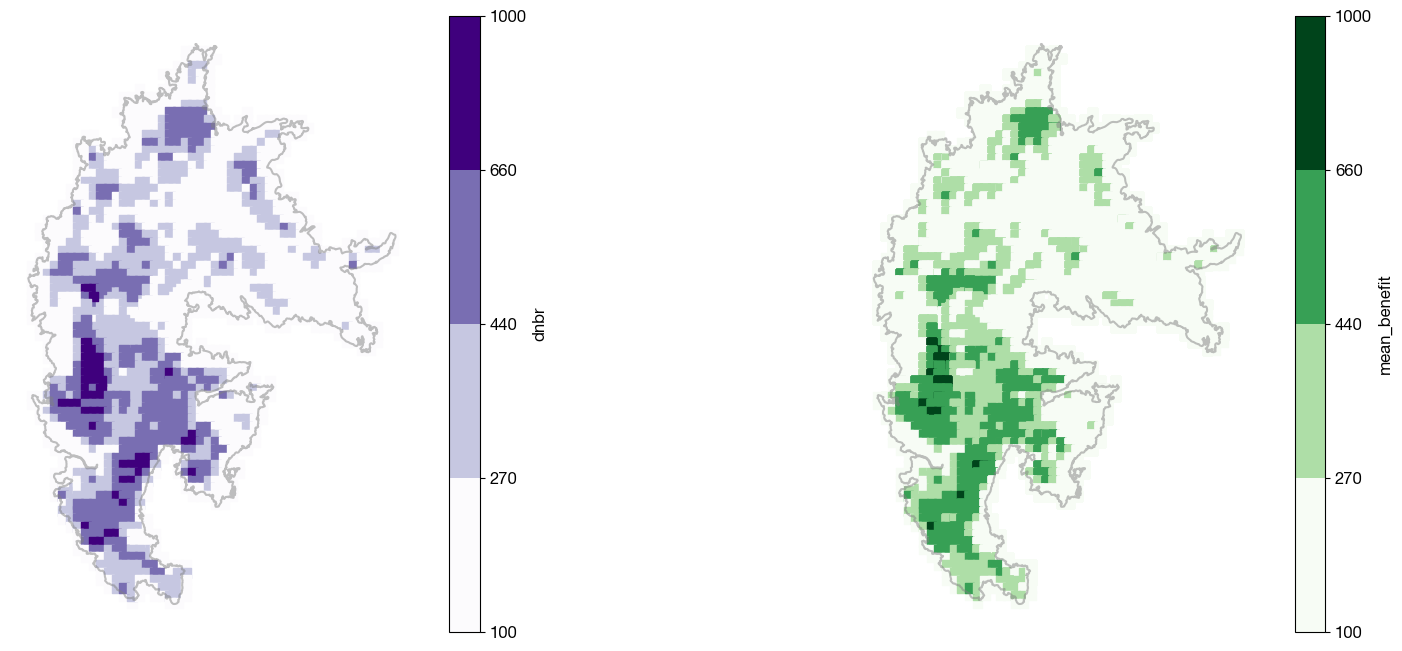

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

# Unify the colorbar for both plots
vmin = treatments_dnbr[
    treatments_dnbr.Event_ID == "CA3720111927220200905"
].dnbr.min()
vmax = treatments_dnbr[
    treatments_dnbr.Event_ID == "CA3720111927220200905"
].dnbr.max()

df_complete.plot(
    x="lon",
    y="lat",
    kind="scatter",
    c="mean_benefit",
    s=45,
    marker=",",
    ax=ax[1],
    cmap="Greens",
    norm=matplotlib.colors.BoundaryNorm(
        boundaries=[100, 270, 440, 660, 1000],
        ncolors=256,
    ),
)

mtbs[mtbs.Event_ID == "CA3720111927220200905"].geometry.boundary.plot(
    ax=ax[1], color="gray", alpha=0.5
)

treatments_dnbr[treatments_dnbr.Event_ID == "CA3720111927220200905"].plot(
    ax=ax[0],
    x="lon",
    y="lat",
    kind="scatter",
    c="dnbr",
    s=50,
    marker=",",
    cmap="Purples",
    colorbar=True,
    norm=matplotlib.colors.BoundaryNorm(
        boundaries=[100, 270, 440, 660, 1000],
        ncolors=256,
    ),
)

mtbs[mtbs.Event_ID == "CA3720111927220200905"].geometry.boundary.plot(
    ax=ax[0], color="gray", alpha=0.5
)

ax[0].axis("off")
ax[1].axis("off")

# Save plot as PDF
plt.savefig(
    "../figs/fire_creek_benefit.pdf",
    bbox_inches="tight",
    dpi=300,
    transparent=True,
)

In [8]:
path = f"{sim_path}/policy_no_spill_4000_large_4000"
df = duckdb.query(f"""
WITH simulation_data AS (
    SELECT *
    FROM '{path}/*.parquet'
    where sim is not null
), 
dnbr_data AS (
select
        grid_id, 
        year, 
        Event_ID as event_id, 
        Incid_Name as event_name, 
        dnbr 
from '../data/dnbr.parquet' 
where year > 2010
), 
dnbr_event_agg as (
select event_id, 
    event_name,      
    year,
    sum(dnbr) as sum_dnbr
from dnbr_data
group by event_id, event_name, year
), 
benefits_grid_simulation as (
SELECT  s.grid_id, 
        s.year_treat, 
        s.year, 
        d.event_id, 
        d.event_name, 
        s.sim,
        s.coeff, 
        d.dnbr,
        case when (d.dnbr + s.coeff) < 0 
                then 0 
                else d.dnbr + s.coeff 
        end as sim_benefit
from simulation_data s 
inner join dnbr_data d
on s.grid_id = d.grid_id 
    and s.year = d.year
) select *
from benefits_grid_simulation
""").to_df()

<Axes: xlabel='Severity ($\\Delta$NBR)', ylabel='Density'>

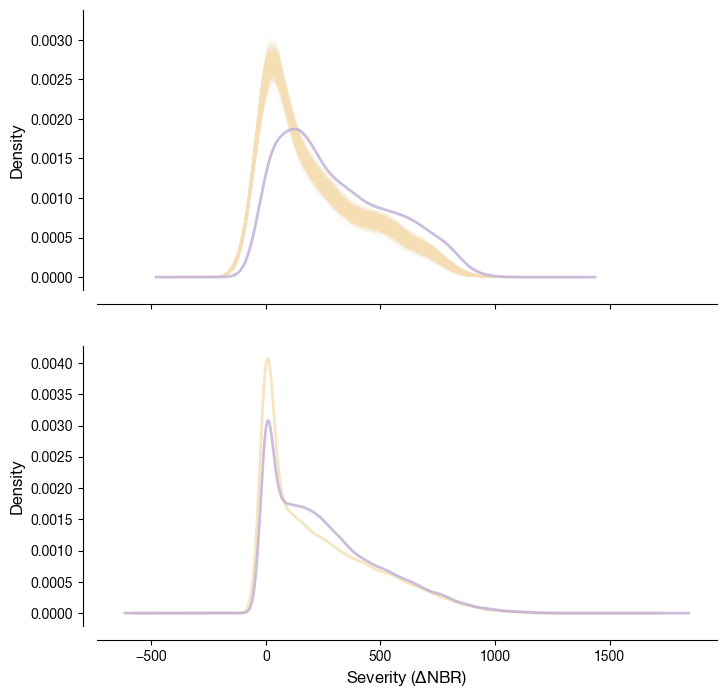

In [9]:
# Plot distribution of benefits
fig, ax = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

sims_event = df[df.event_id == "CA3720111927220200905"]

for sim in df.sim.unique():
    sims_event[(sims_event.sim == sim)].sim_benefit.plot.density(
        ax=ax[0], color="wheat", alpha=0.5, linewidth=0.1
    )

treatments_dnbr[
    treatments_dnbr.Event_ID == "CA3720111927220200905"
].dnbr.plot.density(ax=ax[0], color="#beaed4", linewidth=2, alpha=0.8)

# sims_event.groupby("grid_id").sim_benefit.mean().plot.density(
#     ax=ax[0], color="orange", linewidth=2, alpha=0.5
# )

# Apply template
template_plots(ax[0], xlab="Severity ($\Delta$NBR)", ylab="Density")

# Plot the same, but for all the events
all_sims = (
    df.groupby(["grid_id"])
    .sim_benefit.mean()
    .plot.density(ax=ax[1], color="wheat", linewidth=2, alpha=0.8)
)


treatments_dnbr_clean[
    (treatments_dnbr_clean.year > 2010) & (treatments_dnbr_clean.year < 2021)
].dnbr.plot.density(ax=ax[1], color="#beaed4", linewidth=2, alpha=0.8)


# Apply template
template_plots(ax[1], xlab="Severity ($\Delta$NBR)", ylab="Density")

# Save plot as PDF
# plt.savefig(
#     "../figs/benefits_fire_creek.pdf",
#     bbox_inches="tight",
#     dpi=300,
#     transparent=True,
# )

### Sup Fig: Explore changes in fire severity classes (reality vs. simulations) 

In [34]:
from prescribed.build.build_data import classify_dnbr

path = f"{sim_path}/policy_no_spill_4000_large_4000"
df = duckdb.query(f"""
WITH simulation_data AS (
    SELECT *
    FROM '{path}/*.parquet'
    where sim is not null
), 
dnbr_data AS (
select
        grid_id, 
        year, 
        Event_ID as event_id, 
        Incid_Name as event_name, 
        dnbr 
from '../data/dnbr.parquet' 
where year > 2010
), 
benefits_grid_simulation as (
SELECT  s.grid_id, 
        s.year_treat, 
        s.year, 
        d.event_id, 
        d.event_name, 
        s.sim,
        s.coeff, 
        d.dnbr,
        case when (d.dnbr + s.coeff) < 0 
                then 0 
                else d.dnbr + s.coeff 
        end as sim_benefit
from simulation_data s 
right join dnbr_data d
on s.grid_id = d.grid_id 
    and s.year = d.year
) select
        grid_id,
        year,
        event_id,
        event_name,
        mean(sim_benefit) as sim_benefit,
        mean(dnbr) as dnbr
from benefits_grid_simulation
group by grid_id, event_id, event_name, year
""").to_df()

df = classify_dnbr(
    df,
    "dnbr",
    "dnbr_class",
)

df = classify_dnbr(
    df,
    "sim_benefit",
    "sim_benefit_class",
)


def filter_severity(df, column_name):
    hc_lists = {
        "Low-severity": df[column_name].isin([0, 1]),
        "High-severity": df[column_name].isin([2, 3]),
        "Very high-severity": (df[column_name] > 3),
    }

    return hc_lists


df = df.assign(
    **{
        "dnbr_class": np.select(
            filter_severity(df, "dnbr_class").values(),
            filter_severity(df, "dnbr_class").keys(),
            default=pd.NaT,
        ),
        "dnbr_class_type": np.select(
            filter_severity(df, "sim_benefit_class").values(),
            filter_severity(df, "sim_benefit_class").keys(),
            default=pd.NaT,
        ),
    }
)


In [53]:
from prescribed.utils import expand_grid

df_rx = expand_grid(
    {
        "year": np.arange(2010, 2020),
        "grid_id": np.arange(1, 4001),
        "event_id": ["Rx"],
        "event_name": ["Rx"],
        "sim_benefit": [None],
    }
)
df_rx["dnbr"] = 100

df_rx = classify_dnbr(df_rx, "dnbr", "dnbr_class")

In [54]:
df_rx

,year,grid_id,event_id,event_name,sim_benefit,dnbr,dnbr_class
0,2010,1,Rx,Rx,None,100,1.0
1,2011,1,Rx,Rx,None,100,1.0
2,2012,1,Rx,Rx,None,100,1.0
3,2013,1,Rx,Rx,None,100,1.0
4,2014,1,Rx,Rx,None,100,1.0
...,...,...,...,...,...,...,...
39995,2015,4000,Rx,Rx,None,100,1.0
39996,2016,4000,Rx,Rx,None,100,1.0
39997,2017,4000,Rx,Rx,None,100,1.0
39998,2018,4000,Rx,Rx,None,100,1.0


In [46]:
df

,grid_id,year,event_id,event_name,sim_benefit,dnbr,dnbr_class,sim_benefit_class,dnbr_class_type
0,269421.0,2018.0,CA3924012311020180727,RANCH,338.277832,423.388245,High-severity,2.0,High-severity
1,100922.0,2018.0,CA4094312242720180905,DELTA,216.052933,298.325409,High-severity,1.0,Low-severity
2,115577.0,2018.0,CA4065012263020180723,CARR,0.000000,0.000000,Low-severity,0.0,Low-severity
3,121996.0,2018.0,CA4065012263020180723,CARR,0.000000,0.000000,Low-severity,0.0,Low-severity
4,259360.0,2018.0,CA3924012311020180727,RANCH,244.029132,328.817841,High-severity,1.0,Low-severity
...,...,...,...,...,...,...,...,...,...
36043,NaN,NaN,CA3749712017520120612,GAINES,NaN,192.296385,Low-severity,NaN,NaN
36044,NaN,NaN,CA4001012127720120729,CHIPS,NaN,326.960673,High-severity,NaN,NaN
36045,NaN,NaN,CA4051012242020180624,CREEK,NaN,107.775220,Low-severity,NaN,NaN
36046,NaN,NaN,CA3533311990620190605,BOULDER,NaN,72.686377,Low-severity,NaN,NaN


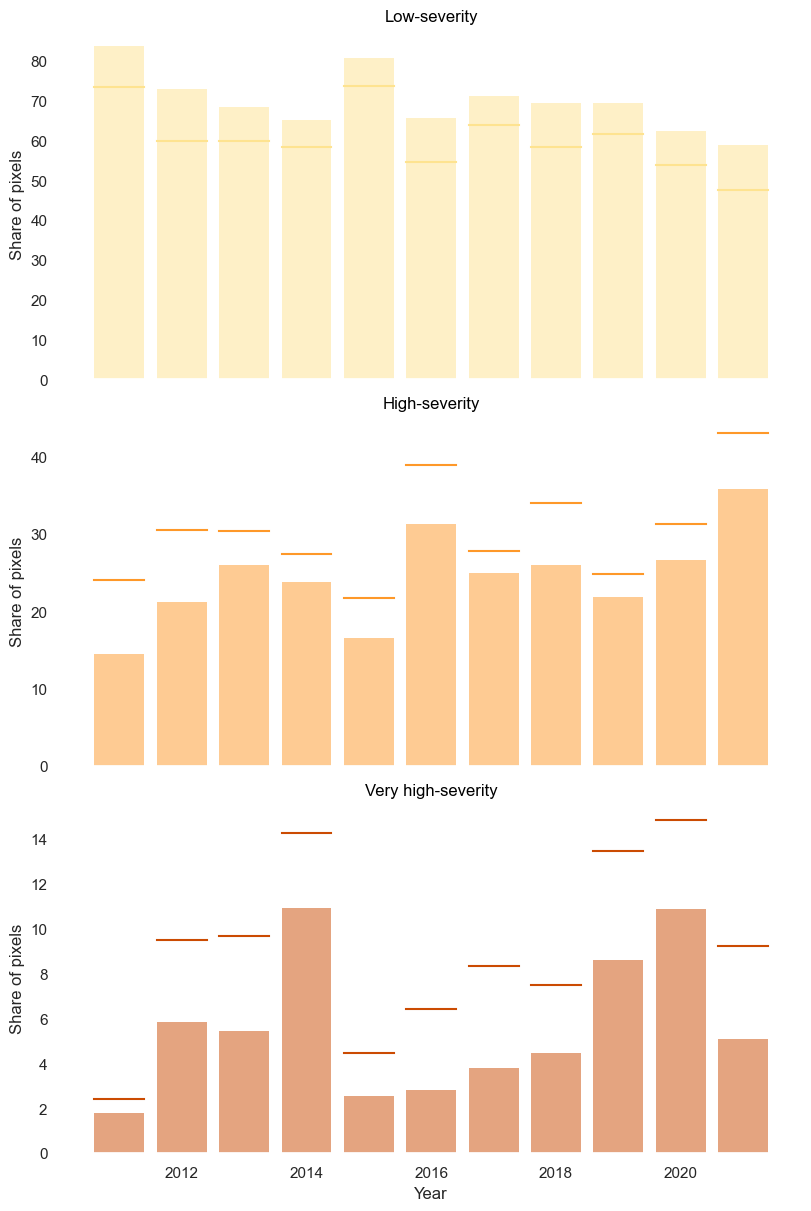

In [35]:
import seaborn.objects as so

severity_ratio = (
    df.dropna()
    .groupby(["year"])["dnbr_class_type"]
    .value_counts(normalize=True)
    .mul(100)
    .round(2)
    .reset_index()
)

severity_ratio_obs = (
    df.dropna()
    .groupby(["year"])["dnbr_class"]
    .value_counts(normalize=True)
    .mul(100)
    .round(2)
    .reset_index()
)


# Merge the two dataframes
severity_ratio = severity_ratio.merge(
    severity_ratio_obs,
    left_on=["year", "dnbr_class_type"],
    right_on=["year", "dnbr_class"],
    how="inner",
    suffixes=("_sim", "_obs"),
)


# Plot the ratio of severity classes in df using the severity_class column
p = (
    so.Plot()
    .add(
        so.Bar(
            alpha=0.5,
            edgewidth=0,
        ),
        so.Stack(),
        data=severity_ratio,
        x="year",
        y="proportion_sim",
        color="dnbr_class_type",
        legend=False,
    )
    .scale(color="YlOrBr")
    .add(
        so.Dash(alpha=1),
        data=severity_ratio,
        x="year",
        y="proportion_obs",
        color="dnbr_class_type",
        legend=False,
    )
    .facet(row=severity_ratio["dnbr_class_type"])
    .theme({"axes.facecolor": "white"})
    .label(y="Share of pixels", x="Year")
    .share(y=False)
    .layout(size=(8, 12), engine="constrained")
).show()


In [32]:
treatments_dnbr_clean_class = classify_dnbr(
    treatments_dnbr_clean, "dnbr", "dnbr_class"
)

severity_ratio_obs = (
    df.dropna()
    .groupby(["year"])["dnbr_class"]
    .value_counts(normalize=True)
    .mul(100)
    .round(2)
    .reset_index()
)

In [33]:
severity_ratio_obs

,year,dnbr_class,proportion
0,2011,Low-severity,73.49
1,2011,High-severity,24.10
2,2011,Very high-severity,2.41
3,2012,Low-severity,59.97
4,2012,High-severity,30.54
5,2012,Very high-severity,9.48
6,2013,Low-severity,59.88
7,2013,High-severity,30.43
8,2013,Very high-severity,9.69
9,2014,Low-severity,58.35


### Check that this is a good fit of $\Delta \text{NBR}$ for $PM_{2.5}$

In [13]:
from prescribed.plot import get_best_poly_fit

# Remove outliers from smoke linked data
smoke_linked = smoke_linked[
    (smoke_linked.sum_severity <= smoke_linked.sum_severity.quantile(0.975))
    & (smoke_linked.sum_severity >= smoke_linked.sum_severity.quantile(0.025))
]

get_best_poly_fit(
    y=smoke_linked[["sum_contrib"]],
    X=smoke_linked[["sum_severity"]],
    degrees=range(1, 10),
)

{'degrees': range(1, 10),
 'rmses': [60810.10028355655,
  60840.61530832897,
  61605.67449490784,
  62804.98501133992,
  64843.651524503664,
  67289.33176151152,
  69449.19705657157,
  70872.17576409252,
  71751.72836014927],
 'best_degree': 1}

## Test

In [4]:
from prescribed.estimate.simulations import sample_rx_years, simulation_data
from prescribed.utils import prepare_template

# Prepare simulation data
sim_data = simulation_data(
    template="/mnt/sherlock/oak/prescribed_data/geoms/templates/template.tif",
    land_type="/mnt/sherlock/oak/prescribed_data/processed/land_type/land_type.feather",
)
sim_data = sim_data[sim_data.land_type.isin([2])]

results = pd.read_csv("../data/results/att_conifers_dnbr_inmediate_new.csv")
results["land_type"] = 2

spillover_results = (
    pd.read_csv("../data/results/att_spillover_new.csv")
    .drop(columns="dist_treat", errors="ignore")
    .sort_values("year")
)

# Prepare template
template = prepare_template(
    "/mnt/sherlock/oak/prescribed_data/geoms/templates/template.tif",
    years=[2010, 2021],
)
template = template[template.year >= 2010]

# Prepare fire data
fire_data = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/treatments_mtbs.feather"
).drop(columns=["spatial_ref"], errors="ignore")
fire_data = fire_data[fire_data.year >= 2010]


In [6]:
list_df = []
for size in [500, 1000, 1500, 2000]:
    test_rx = sample_rx_years(
        template=template,
        treat_data=sim_data,
        estimates=results,
        fire_data=fire_data,
        spillovers=True,
        start_year=2010,
        sample_n=size,
        spillover_estimates=spillover_results,
        size_treatment=1000,
        spillover_size=1000,
    )
    df = test_rx.groupby("year_treat").grid_id.nunique().cumsum()
    df = df.reset_index()
    df.columns = ["year", "size"]

    df["treat_size"] = size

    list_df.append(df)


dfs = pd.concat(list_df, ignore_index=True)

In [7]:
template = "/mnt/sherlock/oak/prescribed_data/geoms/templates/template.tif"
treat_data = sim_data
estimates = results
fire_data = fire_data
spillovers = True
start_year = 2010
spillover_estimates = spillover_results
size_treatment = 1000
spillover_size = 2000
crs = "EPSG:3310"

# Load all datasets
if isinstance(template, str):
    template = prepare_template(template, years=[2000, 2022])
    template = gpd.GeoDataFrame(
        template,
        geometry=gpd.points_from_xy(template.lon, template.lat),
        crs=crs,
    )
    template = template[template.year >= start_year]

# Load fire data
if isinstance(fire_data, str):
    fire_data = pd.read_feather(fire_data).drop(
        columns=["spatial_ref"], errors="ignore"
    )

# Load ATT results from SC
if isinstance(estimates, str):
    estimates = pd.read_csv(estimates)

# Merge treats with the template so we can loop over years!
template = template.merge(
    treat_data.drop(columns=["lat", "lon"], errors="ignore"), on="grid_id"
)
template = template.merge(fire_data, on=["lat", "lon", "year"], how="left")

# Subset for the years we are interested in the treatment data
template = template[template.year >= start_year]

# Remove places with fires to avoid adding controls to places that have fires
# template = template[template.Event_ID.isin([np.nan, "nodata"])]

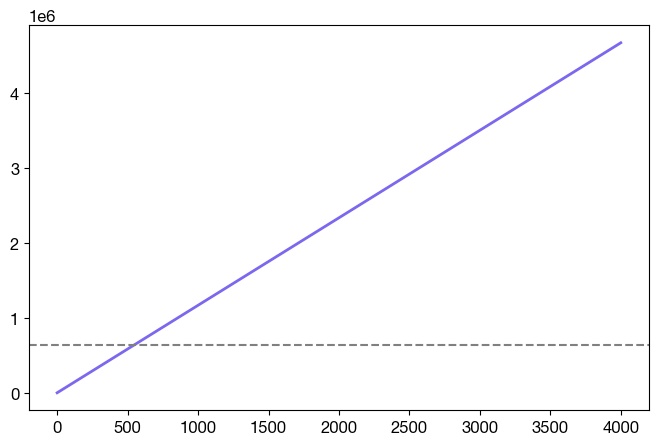

In [8]:
ideal_policy = 4_000
att = 160
spill_att = 42
possible_policies = np.arange(0, ideal_policy + 1, 100)

benefit = ideal_policy * att

benefit_spill = (att * possible_policies) + (24 * possible_policies * spill_att)

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(
    possible_policies,
    benefit_spill,
    label="Spillover Policy",
    color="mediumslateblue",
    linewidth=2,
)
# Do a horizontal line at the benefit of the ideal policy
ax.axhline(
    benefit,
    color="gray",
    linestyle="--",
    label="Ideal Policy Benefit",
)


/tmp/ipykernel_1319682/3701314261.py:13: UserWarning: 
The palette list has fewer values (4) than needed (6) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(


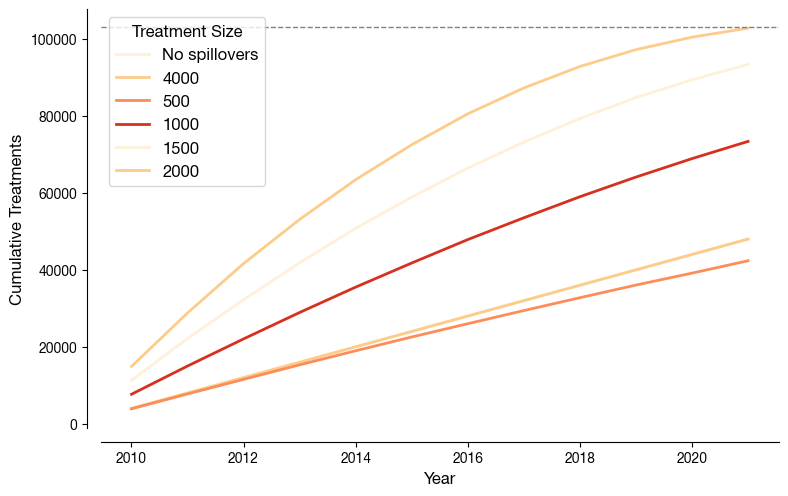

In [14]:
no_spill = pd.DataFrame(
    {
        "year": np.arange(2010, 2022),
        "size": np.cumsum(np.repeat(4000, 12)),
        "treat_size": "No spillovers",
    }
)

dfs = pd.concat([no_spill, dfs], ignore_index=True)

fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(
    data=dfs,
    x="year",
    y="size",
    hue="treat_size",
    palette=[
        "#fef0d9",
        "#fdcc8a",
        "#fc8d59",
        "#d7301f",
    ],
    ax=ax,
    linewidth=2,
)

# Add a horizontal line at y=1000
plt.axhline(y=103000, color="gray", linestyle="--", linewidth=1)
plt.legend(title="Treatment Size", loc="upper left")
plt.tight_layout()

template_plots(
    ax,
    xlab="Year",
    ylab="Cumulative Treatments",
)

# Save the plot
plt.savefig(
    "../figs/cumulative_treatments.png",
    bbox_inches="tight",
    dpi=400,
    transparent=True,
)
